In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import generate_data as gen_d

In [2]:
%matplotlib inline
plt.style.use("fivethirtyeight")

# Exploration

In [3]:
df = pd.read_csv("blackjack.csv")

In [4]:
df.shape

(80000, 18)

In [5]:
df.describe()

,num_decks,dealer_open,dealer_initial,dealer_hit,dealer_num_hits,dealer_final,dealer_busts,player_inital,player_hit,player_num_hits,player_final,player_busts,player_loses,draw,player_wins,strategy
count,80000.0,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000
mean,4.0,6.531025,14.562225,0.409712,0.560350,18.093625,0.178175,14.551288,0.572425,0.845137,19.890013,0.295125,0.54415,0.073188,0.382663,0.500000
std,0.0,3.156198,4.081692,0.491784,0.775268,4.353334,0.382662,4.082601,0.494730,0.900050,3.876442,0.456102,0.49805,0.260446,0.486040,0.500003
min,4.0,1.000000,4.000000,0.000000,0.000000,4.000000,0.000000,4.000000,0.000000,0.000000,4.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,4.0,4.000000,12.000000,0.000000,0.000000,16.000000,0.000000,12.000000,0.000000,0.000000,18.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,4.0,7.000000,15.000000,0.000000,0.000000,19.000000,0.000000,15.000000,1.000000,1.000000,20.000000,0.000000,1.00000,0.000000,0.000000,0.500000
75%,4.0,10.000000,18.000000,1.000000,1.000000,21.000000,0.000000,18.000000,1.000000,1.000000,22.000000,1.000000,1.00000,0.000000,1.000000,1.000000
max,4.0,10.000000,21.000000,1.000000,6.000000,26.000000,1.000000,21.000000,1.000000,6.000000,28.000000,1.000000,1.00000,1.000000,1.000000,1.000000


In [8]:
df.groupby("strategy")[["player_wins"]].mean()

,player_wins
strategy,
0,0.365300
1,0.400025


# Hypothesis testing

$H_0$: There is no difference in results for the player between a random strategy and a recommended strategy.

$H_1$: There is a difference in results for the player between a random strategy and a recommended strategy.

Significance level, $\alpha$: 5%

In [9]:
# Simulate trials of 100 games
def sim_trial():
    ran = gen_d.gen_df(gen_d.gen_data(num_decks=4, df_size=50, strategy=0))
    ran = ran[["dealer_busts", "player_busts", "player_loses", "draw", "player_wins", "strategy"]].sum()/len(ran)
    ran = pd.DataFrame(ran, ["dealer_busts", "player_busts", "player_loses", "draw", "player_wins", "strategy"]).T
    rec = gen_d.gen_df(gen_d.gen_data(num_decks=4, df_size=50, strategy=1))
    rec = rec[["dealer_busts", "player_busts", "player_loses", "draw", "player_wins", "strategy"]].sum()/len(rec)
    rec = pd.DataFrame(rec, ["dealer_busts", "player_busts", "player_loses", "draw", "player_wins", "strategy"]).T
    sub = pd.concat([ran, rec])
    return sub

In [10]:
def n_trials(n=5000):
    trials = sim_trial()
    for _ in range(n-1):
        trials = pd.concat([trials, sim_trial()])
        
    return trials

In [11]:
trials = pd.read_csv("trials.csv")

In [12]:
trials.shape

(50000, 6)

In [13]:
trials.describe()

,dealer_busts,player_busts,player_loses,draw,player_wins,strategy
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.177014,0.295890,0.545973,0.071444,0.382583,0.500000
std,0.071373,0.182232,0.074321,0.036885,0.071278,0.500005
min,0.000000,0.000000,0.240000,0.000000,0.100000,0.000000
25%,0.120000,0.120000,0.500000,0.040000,0.340000,0.000000
50%,0.180000,0.260000,0.540000,0.060000,0.380000,0.500000
75%,0.220000,0.460000,0.600000,0.100000,0.440000,1.000000
max,0.460000,0.820000,0.860000,0.280000,0.680000,1.000000


## Difference between losing, drawing and winning

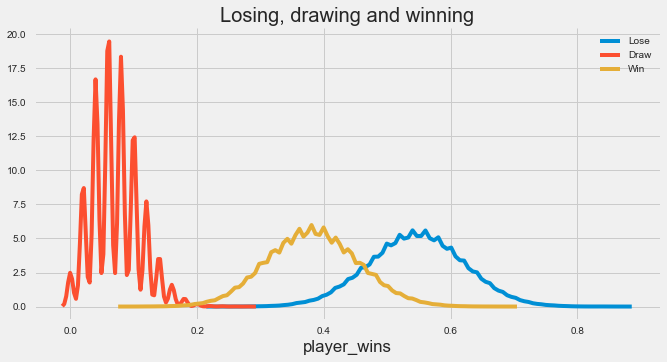

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(trials.player_loses, hist=False, label="Lose");
sns.distplot(trials.draw, hist=False, label="Draw");
sns.distplot(trials.player_wins, hist=False, label="Win");
ax.set_title("Losing, drawing and winning");
sns.despine();

## Losses

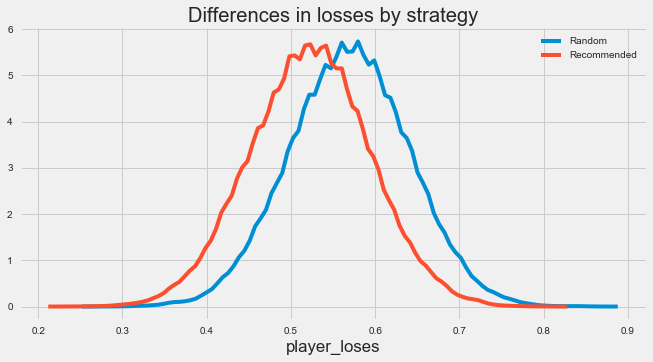

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(trials.player_loses[trials.strategy==0.0], 
             hist=False, label="Random");
sns.distplot(trials.player_loses[trials.strategy==1.0], 
             hist=False, label="Recommended");
ax.set_title("Differences in losses by strategy");
sns.despine();

## Draws

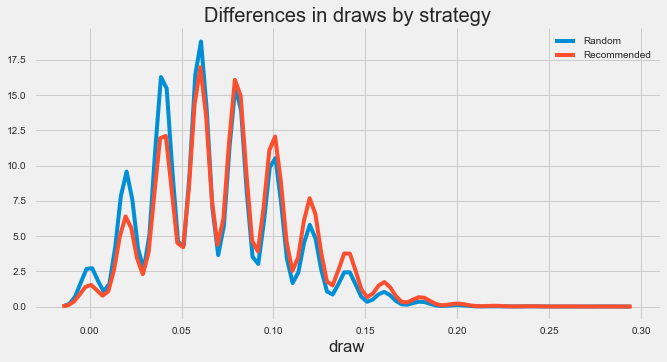

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(trials.draw[trials.strategy==0.0], 
             hist=False, label="Random");
sns.distplot(trials.draw[trials.strategy==1.0], 
             hist=False, label="Recommended");
ax.set_title("Differences in draws by strategy");
sns.despine();

## Wins

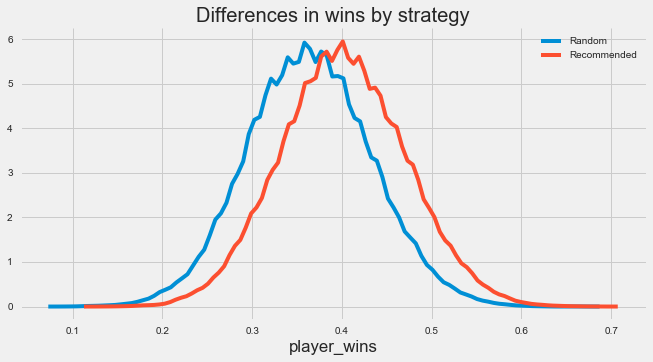

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(trials.player_wins[trials.strategy==0.0], 
             hist=False, label="Random");
sns.distplot(trials.player_wins[trials.strategy==1.0], 
             hist=False, label="Recommended");
ax.set_title("Differences in wins by strategy");
sns.despine();

## Player busting

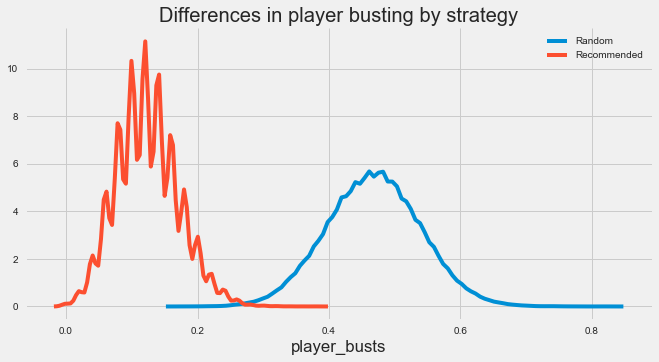

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(trials.player_busts[trials.strategy==0.0], 
             hist=False, label="Random");
sns.distplot(trials.player_busts[trials.strategy==1.0], 
             hist=False, label="Recommended");
ax.set_title("Differences in player busting by strategy");
sns.despine();

## Dealer busting

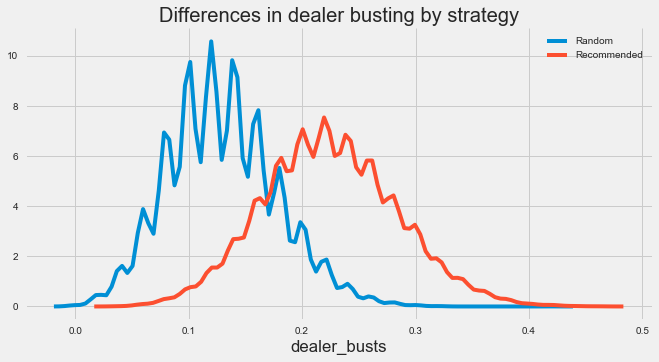

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5));
sns.distplot(trials.dealer_busts[trials.strategy==0.0], 
             hist=False, label="Random");
sns.distplot(trials.dealer_busts[trials.strategy==1.0], 
             hist=False, label="Recommended");
ax.set_title("Differences in dealer busting by strategy");
sns.despine();

# Statistical testing

![t-test](https://camo.githubusercontent.com/3fe864d148f460fadd369d42645f60feebe77672/687474703a2f2f696d616765732e7475746f7276697374612e636f6d2f636d732f696d616765732f3131332f742d746573742d666f726d756c612e706e67)

## Is the difference in the 'rate' of losing between strategies statistically significant?

In [23]:
ran_lose = trials.player_loses[trials.strategy==0]
rec_lose = trials.player_loses[trials.strategy==1]
tt = (np.mean(ran_lose)-np.mean(rec_lose)) / np.sqrt((np.var(ran_lose)/len(ran_lose))+(np.var(rec_lose)/len(rec_lose)))
pval = stats.t.sf(abs(tt), len(rec_lose)-1)
print ("{:.2f}, {:.10f}".format(tt, pval))

74.23, 0.0000000000


## Is the difference in the 'rate' of winning between strategies statistically significant?

In [24]:
ran_win = trials.player_wins[trials.strategy==0]
rec_win = trials.player_wins[trials.strategy==1]
tt = (np.mean(ran_win)-np.mean(rec_win)) / np.sqrt((np.var(ran_win)/len(ran_win))+(np.var(rec_win)/len(rec_win)))
pval = stats.t.sf(abs(tt), len(rec_win)-1)
print ("{:.2f}, {:.10f}".format(tt, pval))

-61.15, 0.0000000000


## Is the difference in the 'rate' of busting between strategies statistically significant?

In [25]:
ran_busts = trials.player_busts[trials.strategy==0]
rec_busts = trials.player_busts[trials.strategy==1]
tt = (np.mean(ran_busts)-np.mean(rec_busts)) / np.sqrt((np.var(ran_busts)/len(ran_busts))+(np.var(rec_busts)/len(rec_busts)))
pval = stats.t.sf(abs(tt), len(rec_busts)-1)
print ("{:.2f}, {:.10f}".format(tt, pval))

640.42, 0.0000000000


In [27]:
ran_dbusts = trials.dealer_busts[trials.strategy==0]
rec_dbusts = trials.dealer_busts[trials.strategy==1]
tt = (np.mean(ran_dbusts)-np.mean(rec_dbusts)) / np.sqrt((np.var(ran_dbusts)/len(ran_dbusts))+(np.var(rec_dbusts)/len(rec_dbusts)))
pval = stats.t.sf(abs(tt), len(rec_dbusts)-1)
print ("{:.2f}, {:.10f}".format(tt, pval))

-198.09, 0.0000000000


# Looking at the dataset

In [28]:
df.head()

,num_decks,dealer_open,dealer_initial,dealer_hit,dealer_num_hits,dealer_final,dealer_busts,player_inital,player_hit,player_num_hits,player_final,player_busts,player_loses,draw,player_wins,strategy,dealer_hand,player_hand
0,4,2,12,1,2,23,1,19,0,0,19,0,0,0,1,0,"[2, 'K', 3, 8]","['A', 8]"
1,4,3,13,1,2,18,0,16,1,1,19,0,0,0,1,0,"[3, 'K', 'A', 4]","['J', 6, 3]"
2,4,7,15,0,0,15,0,14,1,1,24,1,1,0,0,0,"[7, 8]","[4, 'K', 'Q']"
3,4,10,19,0,0,19,0,7,1,2,22,1,1,0,0,0,"[10, 9]","[4, 3, 'K', 5]"
4,4,7,17,0,0,17,0,11,1,2,22,1,1,0,0,0,"[7, 'J']","[4, 7, 'A', 'Q']"


## Analysis by one card

- To determine if we want to split
- Look at the probability of winning based on one card
    - Use first card for simplicity

In [34]:
df["player_hand"][0].replace("'", "").strip("[]").replace(",", " ").split()

['A', '8']

In [41]:
df["player_card_one"] = df["player_hand"].map(lambda x: x.replace("'", "").strip("[]").replace(",", " ").split()[0])
df["player_card_one"] = df["player_card_one"].map(lambda x: 10 if x in ["J", "Q", "K"] else 1 if x == "A" else int(x))

In [45]:
one_card = df.groupby(["player_card_one", "strategy"])[["player_loses", "draw", "player_wins"]].sum()
one_card.reset_index(inplace=True)
one_card.head()

,player_card_one,strategy,player_loses,draw,player_wins
0,1,0,1072,236,1780
1,1,1,1131,218,1703
2,2,0,1991,198,958
3,2,1,1856,177,1080
4,3,0,1955,176,951


In [48]:
one_card["cases"] = one_card[["player_loses", "draw", "player_wins"]].apply(sum, axis=1)

In [51]:
for i in ["player_loses", "draw", "player_wins"]:
    one_card["p_"+i] = one_card[i]/one_card["cases"]

In [52]:
one_card.head()

,player_card_one,strategy,player_loses,draw,player_wins,cases,p_player_loses,p_draw,p_player_wins
0,1,0,1072,236,1780,3088,0.347150,0.076425,0.576425
1,1,1,1131,218,1703,3052,0.370577,0.071429,0.557995
2,2,0,1991,198,958,3147,0.632666,0.062917,0.304417
3,2,1,1856,177,1080,3113,0.596209,0.056858,0.346932
4,3,0,1955,176,951,3082,0.634328,0.057106,0.308566


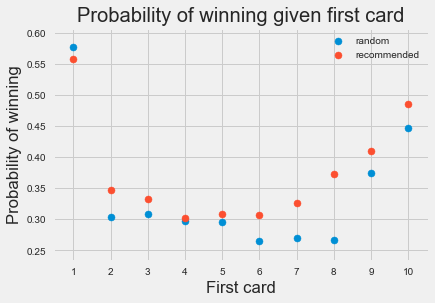

In [61]:
plt.scatter(one_card[one_card["strategy"]==0][["player_card_one"]], 
            one_card[one_card["strategy"]==0][["p_player_wins"]], label="random");
plt.scatter(one_card[one_card["strategy"]==1][["player_card_one"]], 
            one_card[one_card["strategy"]==1][["p_player_wins"]], label="recommended");
plt.legend();
plt.title("Probability of winning given first card");
plt.xlabel("First card");
plt.xticks(np.arange(1,11));
plt.ylabel("Probability of winning");